In [9]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import cv2
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [2]:
from Dataset import SIIMDataset

In [3]:
RLE_DF_ALL = pd.read_csv('Data/train-rle.csv')

# Rename Column Names
RLE_DF_ALL.columns = ['ImageId', 'EncodedPixels']

# Drop duplicate values in ImageId column
RLE_DF = RLE_DF_ALL.drop_duplicates('ImageId')

RLE_DF_WITH_MASK = RLE_DF[RLE_DF["EncodedPixels"] != " -1"]
RLE_DF_WITH_MASK['has_mask'] = 1

RLE_DF_WITHOUT_MASK = RLE_DF[RLE_DF["EncodedPixels"] == " -1"]
RLE_DF_WITHOUT_MASK['has_mask'] = 0
RLE_DF_WITHOUT_MASK_SAMPLED = RLE_DF_WITHOUT_MASK.sample(len(RLE_DF_WITH_MASK), random_state=69)

RLE_DF = pd.concat([RLE_DF_WITH_MASK, RLE_DF_WITHOUT_MASK_SAMPLED])

RLE_DF.head()

<ipython-input-3-e9cd21a979a3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RLE_DF_WITH_MASK['has_mask'] = 1
<ipython-input-3-e9cd21a979a3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RLE_DF_WITHOUT_MASK['has_mask'] = 0


,ImageId,EncodedPixels,has_mask
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1
7,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,119331 47 972 82 937 107 912 122 897 137 882 ...,1
10,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,532609 13 1005 19 1002 21 999 25 989 32 988 3...,1
11,1.2.276.0.7230010.3.1.4.8323329.4982.151787518...,291062 6 1015 10 1013 11 1011 13 1010 13 1010...,1


In [4]:
kfold = StratifiedKFold(5, shuffle=True, random_state=69)
train_idx, val_idx = list(kfold.split(RLE_DF["ImageId"], RLE_DF["has_mask"]))[0]
Train_DF, Val_DF = RLE_DF.iloc[train_idx], RLE_DF.iloc[val_idx]

In [5]:
image_dataset = SIIMDataset(RLE_DF_ALL, Train_DF['ImageId'].values, 'Data/UnPacked/train_png')

dataloader = DataLoader(
    image_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
)

In [6]:
batch = next(iter(dataloader))
images, masks = batch

In [13]:
masks.shape

torch.Size([16, 512, 512])

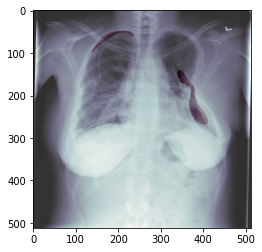

Chosen image has no ground truth mask, rerun the cell


In [24]:
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

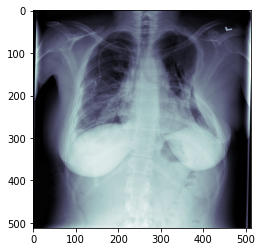

In [25]:
plt.imshow(images[idx][0], cmap='bone')

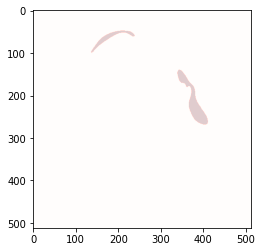

In [26]:
plt.imshow(masks[idx], alpha=0.2, cmap='Reds')

In [1]:
from Model import Unet

In [2]:
model = Unet("resnet34", encoder_weights="imagenet", activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\hagar/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
 65%|██████▍   | 53.7M/83.3M [00:49<00:24, 1.27MB/s]